# Finetuning with Trainer/Validation of saved models/Prompting wth OpenAI-like API
This notebook is used for development of few tasks: 
- finetuning of text classifiation models
- validating saved models
- communicating with OpenAI-like API

They will be divided into separate notebooks, but as for now it's more convenient to keep them here, while common part of their pipelines are changed almost each commit. 

data source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx

In [26]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
   colab = True
else:
   colab = False

if colab:
    !pip install transformers[torch]
    !pip install accelerate -U
    !pip install datasets
    !pip install torchinfo
    #ImportError: Using the `Trainer` with `PyTorch` requires `accelerate>=0.20.1`: Please run `pip install transformers[torch]` or `pip install accelerate -U

In [27]:
from sklearn.model_selection import train_test_split
import datetime
import itertools
import matplotlib.pyplot as plt
import numpy as np
import glob
import pandas as pd
import pathlib
import seaborn as sn
import torch
import numbers

from tqdm.autonotebook import tqdm
from datasets import load_dataset, Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torchinfo import summary
from transformers import AutoModelForSequenceClassification, AutoConfig, Trainer, TrainingArguments, DataCollatorWithPadding, AutoTokenizer, pipeline
from transformers.modelcard import parse_log_history

# Prepare parameters for each run of finetuning

## Functions

In [28]:
# Prepare functions

def csv_to_ds(path, binary, split, balanced=False):
    """
    Reads a CSV file, processes the data, and transforms it into a dataset ready for next steps.

    Args:
        path (str): The path to the CSV file.
        binary (bool): Flag indicating whether to convert labels to binary classification.
        split (tuple): A tuple of floats defining the train/test split ratios.
                      Example: [0.7, 0.3] for 70% train, 30% test. Can include an optional third element for validation.
        balanced (bool): Flag indicating whether to balance training dataset or not.

    Returns:
        tuple: A tuple containing:
            * dataset: The processed dataset suitable for machine learning.
            * tg_map: A dictionary mapping target labels to numerical values.
            * reversed_tg_map: A dictionary mapping numerical values back to original labels.
    """
    # csv to df
    new_df = pd.read_excel(path)
    new_df['label'] = new_df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
    new_df = new_df.rename(columns={'Sentence':'sentence'})
    if binary:
        new_df['label'] = new_df['label'].apply(lambda x: to_binary_classification(x))

    # target map and reversed target map
    tg_map = {k:i for i,k in enumerate(new_df['label'].unique())}
    reversed_tg_map = {v:k for k, v in tg_map.items()}

    ds = df_to_ds(new_df, split, tg_map, balanced=balanced)
    return ds, tg_map, reversed_tg_map

def to_binary_classification(x, convert_dict={"Positive":'Pathos', 'Negative':'Pathos'}):
    """
    Converts labels to binary classification ('Pathos' or 'No_pathos').

    Args:
        x (str): The original label.
        convert_dict (dict, optional): A dictionary mapping original labels
            to their corresponding binary representation. Defaults to
            {"Positive":'Pathos', 'Negative':'Pathos'}.

    Returns:
        str: The converted binary label.
    """
    if x in convert_dict.keys():
        return convert_dict[x]
    else:
        return x

def df_to_ds(df, split, tg_map, balanced=False):
    """
    Converts a DataFrame into a Hugging Face DatasetDict, applying label mapping and optional dataset splitting and balancing.

    Args:
        df (pd.DataFrame): The DataFrame containing text data (column 'sentence') and labels (column 'label').
        split (tuple): A tuple of floats defining the train/test split ratios.
                      Example: [0.7, 0.3] for 70% train, 30% test. Can include an optional third element for validation.
        tg_map (dict): A dictionary mapping original labels to numerical indices.
        balanced (bool, optional): If True, balances the training dataset by sampling with respect to class frequencies. Defaults to False.

    Returns:
        DatasetDict: A Hugging Face DatasetDict containing splits ('train', 'test', and optionally 'validate').
    """
    df['label'] = df['label'].map(tg_map)
    if balanced:
        train_test = [pd.Series(name='sentence'), pd.Series(name='sentence'), pd.Series(name='label'), pd.Series(name='label')]
        n_for_training = df.groupby('label').count()['Source'].min()
        train_percentage = df.groupby('label').count()['Source'].apply(lambda x: (split[0]*n_for_training)/x).to_dict()

        for label_name, group in df.groupby('label'):
            train_test_group = train_test_split(group['sentence'], group['label'], test_size=1-train_percentage[label_name], random_state=42, shuffle=True)
            train_test = [pd.concat([i[0],i[1]], axis=0) for i in zip(train_test, train_test_group)]
    else:
        train_test = train_test_split(df['sentence'], df['label'], stratify=df['label'], test_size=split[1], random_state=42, shuffle=True)

    ds = DatasetDict()
    ds['train'] = Dataset.from_pandas(pd.concat([train_test[0], train_test[2]], axis=1))
    if len(split)==2:
        ds['test'] = Dataset.from_pandas(pd.concat([train_test[1], train_test[3]], axis=1))
    elif len(split)==3:
        val_ratio = split[2]/(split[1]+split[2])
        test_validate = train_test_split(train_test[1], train_test[3], stratify=train_test[3], test_size=val_ratio, random_state=42, shuffle=True)
        ds['test'] = Dataset.from_pandas(pd.concat([test_validate[0], test_validate[2]], axis=1))
        ds['validate'] = Dataset.from_pandas(pd.concat([test_validate[1], test_validate[3]], axis=1))

    return ds

# Train functions

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels
  predictions = np.argmax(logits, axis=-1)
  acc = np.mean(predictions == labels)
  f1 = f1_score(labels, predictions, average='macro')
  return {'accuracy': acc, 'f1': f1}

def save_logs_from_training_run(trainer, params, timestamp, trained_model_path, colab, target_map):
    """
    Collects training logs, metadata, and performance metrics, saving them to a CSV file for tracking.

    Args:
        trainer (Trainer): The Hugging Face Trainer object.
        params (dict): A dictionary containing model and training parameters.
        timestamp (str): Datetime string for identifying the training run.
        trained_model_path (str): The output path where the trained model is saved.
        colab (bool): Indicates whether the code was run in Google Colab.
        target_map (dict): A mapping of original labels to numerical indices.
    """
    log_history = parse_log_history(trainer.state.log_history)
    log_df = pd.DataFrame(log_history[1])
    log_df.insert(0, 'model', params['model'])
    log_df.insert(0, 'timestamp', timestamp)
    log_df['model_path'] = trained_model_path
    log_df['samples_per_s'] = log_history[0]['train_samples_per_second']
    log_df['steps_per_s'] = log_history[0]['train_steps_per_second']
    log_df['colab'] = colab
    log_df['per_device_train_batch_size'] = params['per_device_train_batch_size']
    log_df['per_device_eval_batch_size'] = params['per_device_eval_batch_size']
    log_df['split'] = str(params['split'])
    log_df['target_map'] = str(target_map)
    log_df['binary'] = params['binary']
    log_df['balanced'] = params['balanced']

    float_cols = log_df.select_dtypes(include='float64')
    log_df[float_cols.columns] = float_cols.apply(lambda x: round(x, 3))

    log_path = os.path.join(project_root, 'output/training_logs.csv')
    log_df.to_csv(log_path, mode='a', header= not os.path.isfile(log_path), index=False)

def finetune(params, ds, target_map, save_logs):
    """
    Fine-tunes a pre-trained language model for text classification. Handles tokenization, model loading, and training.

    Args:
        params (dict): A dictionary containing model and training parameters.
        ds (DatasetDict): A Hugging Face DatasetDict containing 'train', 'test', and optionally 'validate' splits.
        target_map (dict): A mapping of original labels to numerical indices.
        save_logs (bool): If True, saves training logs and metrics.
    """
    params_passed = {k: params[k] for k in params if k not in ['model', 'split', 'binary', 'balanced']}
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
    trained_model_path = f"output/models/{params['model']}_{timestamp}"
    try:
        def tokenize_fn(batch):
            return tokenizer(batch['sentence'], truncation=True)

        #Tokenize dataset
        tokenizer = AutoTokenizer.from_pretrained(params['model'], trust_remote_code=True)
        # tokenizer.pad_token = tokenizer.eos_token
        if tokenizer.pad_token is None:
            # tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            tokenizer.add_special_tokens({'pad_token': '<pad>'})
            # model.resize_token_embeddings(len(tokenizer))
        tokenized_datasets = ds.map(tokenize_fn, batched=True)

        # data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

        #Change labels
        config = AutoConfig.from_pretrained(params['model'], trust_remote_code=True)
        config.vocab_size = tokenizer.vocab_size
        config.id2label = reversed_target_map
        config.label2id = target_map

        #Load model
        model = AutoModelForSequenceClassification.from_pretrained(
            params['model'], config=config, ignore_mismatched_sizes=True, trust_remote_code=True)

        if tokenizer.pad_token is None:
            tokenizer.add_special_tokens({'pad_token': '[PAD]'})
            model.resize_token_embeddings(len(tokenizer))

        training_args = TrainingArguments(
          output_dir=os.path.join(project_root, f'{trained_model_path}/checkpoints'),
          evaluation_strategy='epoch',
          logging_strategy='epoch',
          use_cpu = False,
          **params_passed
        )

        trainer = Trainer(
            model,
            training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["test"],
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            # data_collator=data_collator,
        )

        trainer.train()
        if save_logs:
            save_logs_from_training_run(trainer, params, timestamp, trained_model_path, colab, target_map)

    except Exception as e:
        print(f'Error: {e}')
        if save_logs:
            err_df = pd.DataFrame([[trained_model_path, str(e)]])
            err_path = os.path.join(project_root, 'output/error_logs.csv')
            err_df.to_csv(err_path, mode='a', header= not os.path.isfile(err_path), index=False)

# Validate functions

def get_log_for_val(checkpoint_path, logs_path, sort_col='Step'):
    """
    Retrieves the training log entry corresponding to a given checkpoint.

    Args:
        checkpoint_path (str): The path to the checkpoint directory.
        logs_path (str): The path to the CSV file containing the training logs.
        sort_col (str, optional): The column to sort by when searching for the latest checkpoint. Defaults to 'Step'.

    Returns:
        pd.Series: A Pandas Series representing a single row of the training logs.
    """
    training_logs = pd.read_csv(logs_path)
    if 'checkpoint-' in checkpoint_path:
        temp_path = checkpoint_path.rsplit('models/', 1)[-1]
        model_path, checkpoint_num = temp_path.rsplit('/checkpoints/checkpoint-')
        row = training_logs[(training_logs['model_path'].apply(lambda x: x.rsplit('models/', 1)[-1] == model_path)) & (training_logs['Step'] == int(checkpoint_num))]
    else:
        row = training_logs[training_logs['model_path'] == checkpoint_path].sort_values(sort_col, ascending=False).head(1)
    return row.iloc[0]

def validate(row, ds):
    """
    Loads a trained model from a checkpoint and evaluates its performance on the validation set.

    Args:
        row (pd.Series): A single row from the training logs, containing checkpoint information.
        ds (DatasetDict): A Hugging Face DatasetDict containing a 'validate' split.

    Returns:
        tuple: A tuple containing:
            * predicted (list): List of predicted labels.
            * val_labels (list): List of true labels.
    """
    val_sentences = ds['validate']['sentence']
    val_labels = [reversed_target_map[i] for i in ds['validate']['label']]

    classifier = pipeline('text-classification', model=os.path.join(row['model_path'], 'checkpoints', f"checkpoint-{row['Step']}"), device=0)
    predicted = [i['label'] for i in classifier(val_sentences)]
    return predicted, val_labels

def val_metrics(predicted, val_labels, target_map):
    """
    Calculates and displays validation metrics (accuracy, F1-score, confusion matrix).

    Args:
        predicted (list): List of predicted labels.
        val_labels (list): List of true labels.
        target_map (dict): A mapping of original labels to numerical indices.
    """
    print("acc:", accuracy_score(val_labels, predicted))
    print("f1:", f1_score(val_labels, predicted, average='macro'))

    cm = confusion_matrix(val_labels, predicted, normalize='true')
    plot_cm(cm, target_map)

def plot_cm(cm, target_map):
    classes = list(target_map.keys())
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    ax = sn.heatmap(df_cm, annot=True, fmt='.2g')
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Target")


## Finetuning with Trainer

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

# models = ['albert', 'bart', 'bert', 'big_bird', 'bigbird_pegasus', 'biogpt', 'bloom', 'camembert', 'canine', 'code_llama', 'convbert', 'ctrl', 'data2vec-text', 'deberta', 'deberta-v2', 'distilbert', 'electra', 'ernie', 'ernie_m', 'esm', 'falcon', 'flaubert', 'fnet', 'funnel', 'gemma', 'gpt-sw3', 'gpt2', 'gpt_bigcode', 'gpt_neo', 'gpt_neox', 'gptj', 'ibert', 'layoutlm', 'layoutlmv2', 'layoutlmv3', 'led', 'lilt', 'llama', 'longformer', 'luke', 'markuplm', 'mbart', 'mega', 'megatron-bert', 'mistral', 'mixtral', 'mobilebert', 'mpnet', 'mpt', 'mra', 'mt5', 'mvp', 'nezha', 'nystromformer', 'open-llama', 'openai-gpt', 'opt', 'perceiver', 'persimmon', 'phi', 'plbart', 'qdqbert', 'qwen2', 'reformer', 'rembert', 'roberta', 'roberta-prelayernorm', 'roc_bert', 'roformer', 'squeezebert', 'stablelm', 'starcoder2', 't5', 'tapas', 'transfo-xl', 'umt5', 'xlm', 'xlm-roberta', 'xlm-roberta-xl', 'xlnet', 'xmod', 'yoso',]
# =============================================
# tested = 'distilbert-base-cased', 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'
# ----------
#too weak pc (cannot be loaded or runs at speeds <1 it/s) = 'albert-xlarge-v1', 't5-11B', 'LongformerForSequenceClassification', 'xlm-roberta-base', 'allenai/longformer-base-4096', 'facebook/bart-large',  flaubert/flaubert_large_cased (stopped at 0.5 epoch),
# ----------
# need changes to run (check error logs) =  ProsusAI/finbert (despite adding padding proposed in error)
# =============================================
# model_path = 'SamLowe/roberta-base-go_emotions'
# model_path = 'distilbert-base-uncased'
# model_path = 'xlmoberta'

# , 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base', 'flaubert/flaubert_base_cased'

# deprecated: transfo-xl-wt103

In [ ]:
#if list of objects is provided list of all combinations of parameters will be created for running
params_tested = {'model': ['flaubert/flaubert_base_cased', 'distilbert-base-cased', 'camembert-base', 'ctrl', 'xlnet-base-cased', 'roberta-base', 'distilroberta-base'], # Pre-trained model names from the Hugging Face hub used for fine-tuning
                 'num_train_epochs': 10, # Number of times the model sees the entire training dataset.
                 'save_strategy': 'no', # Controls when to save model checkpoints ('epoch' or 'no').
                 'per_device_train_batch_size': 8, # Number of samples processed in each training step (personally, 8/16 work best, but 16 may find linear drop in inference speed during fine-tuning).
                 'per_device_eval_batch_size': 64, # Number of samples processed in each evaluation step.
                 'split': (80, 10, 10), # Divides the dataset into training, testing, (and optionally) validation sets. Use 'balanced' for equal class representation in the validation set. Examples: (90,10) -> split into train and test proportionally; (80, 10, 10) splits into train,test, validate proportionally.
                 'binary': [True, False], # Indicates whether the task is binary (two classes) or multi-class classification.,
                 'balanced': [True, False], # his way labels used for training are split evenly, fitting size to the lowest label count. n (equal to 80% of least represented label) will be taken from each label, rest will be used for test.
                 }

# Controls whether to save logs during a process. When set to False, logging is disabled.
save_logs = True

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    project_root = '/content/drive/Othercomputers/My computer/EQILLM/'
else:
    project_root = ''


def ratio_split_tuple(split):
    split_s = sum([i for i in split if isinstance(i, numbers.Integral)])
    new_split = tuple([i/split_s if isinstance(i, numbers.Integral) else i for i in split])
    return new_split

if isinstance(params_tested['split'], list):
    params_tested['split'] = list(map(ratio_split_tuple, params_tested['split']))
else:
    params_tested['split'] = ratio_split_tuple(params_tested['split'])

params_tested={i:[q] if type(q) is not list else q for (i,q) in params_tested.items()}
keys = list(params_tested.keys())
combinations = list(itertools.product(*params_tested.values()))
result = [{keys[i]: combination[i] for i in range(len(keys))} for combination in combinations]
print(*result, sep='\n')

train_params_looped = result

In [18]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    project_root = '/content/drive/Othercomputers/My computer/EQILLM/'
else:
    project_root = ''

data_path = os.path.join(project_root, 'data/PolarIs-Pathos.xlsx')

#run looped
for train_params in train_params_looped:
    dataset, target_map, reversed_target_map = csv_to_ds(data_path, train_params['binary'], train_params['split'], train_params['balanced'])
    finetune(train_params, dataset, target_map, save_logs)

(0.8, 0.1, 0.1)


C:\Users\Jakub\AppData\Local\Temp\ipykernel_24012\1050889934.py:74: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  train_test = [pd.concat([i[0],i[1]], axis=0) for i in zip(train_test, train_test_group)]


Map:   0%|          | 0/7920 [00:00<?, ? examples/s]

Map:   0%|          | 0/3834 [00:00<?, ? examples/s]

Map:   0%|          | 0/3834 [00:00<?, ? examples/s]

Some weights of FlaubertForSequenceClassification were not initialized from the model checkpoint at flaubert/flaubert_base_cased and are newly initialized: ['sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\Jakub\DataspellProjects\EQILLM\venv\Lib\site-packages\accelerate\accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

## Validate

acc: 0.7346153846153847
f1: 0.5655779668969911


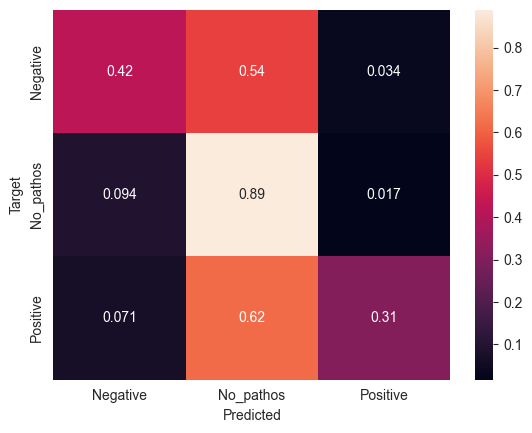

In [9]:
# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx

if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    project_root = '/content/drive/Othercomputers/My computer/EQILLM/'
else:
    project_root = ''

data_path = os.path.join(project_root, 'data/PolarIs-Pathos.xlsx')
checkpoint_path = 'output/models/michellejieli/emotion_text_classifier_2024-04-14_23-58/checkpoints/checkpoint-5262'

val_row = get_log_for_val(checkpoint_path, os.path.join(project_root, 'output/training_logs.csv'))
val_row['split'] = tuple([float(i) for i in val_row['split'][1:-1].split(', ')])
val_row['model_path'] = os.path.join(project_root, val_row['model_path'])

dataset, target_map, reversed_target_map = csv_to_ds(data_path, val_row['binary'], val_row['split'])
predicted_labels, true_labels = validate(val_row, dataset)
val_metrics(predicted_labels, true_labels, target_map)

# Prompting

In [31]:
import pandas as pd
from openai import OpenAI
import openai
import datetime
import os
import tqdm
import csv

# Load PolarIs-Pathos to df
# source: https://github.com/kaatkaa/PolarIs-Corpora/blob/main/PolarIs-Full-Corpus/PolarIs-Full-Corpus-Pathos/PolarIs-Pathos.xlsx
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    project_root = '/content/drive/Othercomputers/My computer/EQILLM/'
else:
    project_root = ''

data_path = os.path.join(project_root, 'data/PolarIs-Pathos.xlsx')
# dataset, target_map, reversed_target_map = csv_to_ds(data_path, binary=False, split=(0.8, 0.1, 0.1))
# val_txts, val_labels = dataset['validate']['sentence'], dataset['validate']['label']
df = pd.read_excel(data_path)
df['label'] = df[['No_pathos', 'Positive', 'Negative']].idxmax(axis=1)
val_txts, val_labels = df['Sentence'], df['label']

In [32]:
def create_messages(text='_'):
    return [
        {
            "role": "system",
            "content": """You are an analytical tool designed on identifying and categorizing pathos within messages. The goal is to annotate whether or not each given text unit contains pathos, and if so, determine whether it appeals to positive, negative, or text doesn't contain pathos. Use your understanding of general cultural knowledge and linguistic cues present in the language to make accurate assessments. Things to take under consideration, but your response mustn't answer to any of those explicitly: 1. can you provide examples of how linguistic cues may indicate positive or negative emotions in a text unit? 2. How should annotators handle cases where it's ambiguous if a statement elicits any emotional response, and is there a need to consider context in these instances? 3. In the case of mixed pathos emotions, how should annotators prioritize identifying the dominant emotion when annotating? 4. How might sarcasm or irony affect the emotional interpretation and subsequent annotations within social media conversations?
            
            Note, the only responses to consider are: 'positive pathos', 'negative pathos' or 'no pathos'. If the intention is ambiguous, respond with 'unclear'. Respond in short manner, with only one of: 'positive pathos', 'negative pathos', 'no pathos', 'unclear'.
                       
            Examples (text -> response):
            'Forget the looks, she’s a freaking liar, fraud, sociopath non-MD!' -> 'negative pathos'
            'I honestly don't understand why this tech has not expanded to ubiquitous use.' -> 'no pathos'
            'I made $5 an hour driving a tractor at age 12 in South Dakota' -> 'positive pathos'
            """
        },
        {
            "role": "user",
            "content": f"Analyze the following text for pathos: {text}"
        },
        {
            "role": "assistant",
            "content": "Identify text with one of: 'positive pathos', 'negative pathos', 'no pathos'. If uncertain, respond with 'unclear'. Do not identify anything not listed."
        }
    ]

client = openai.OpenAI(base_url="http://localhost:1234/v1",  api_key="lm-studio")
model_name = client.models.list().data[0].dict()['id']

prompt_log_path = os.path.join(project_root, 'output', 'prompting', 'prompt_log.csv')
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
response_log_path = os.path.join(project_root, 'output', 'prompting', 'responses', f'{timestamp}.csv')



with open(prompt_log_path, mode='a+', newline='') as csv_file:
    writer = csv.writer(csv_file,  delimiter='|')
    if not os.path.exists(prompt_log_path):
        writer.writerow(['model', 'timestamp', 'message_system', 'message_user', 'message_assistant'])
    writer.writerow([model_name, timestamp, *create_messages()])

with open(response_log_path, mode='a+', newline='', encoding="utf-8") as csv_file:
    writer = csv.writer(csv_file,  delimiter='|')
    writer.writerow(['sentence', 'label', 'timestamp', 'response'])
    
    for i, (txt, label) in tqdm.tqdm(enumerate(zip(val_txts, val_labels))): # iterate through each text value of first df column
        completion = client.chat.completions.create(
            model="local-model", # this field is currently unused
            messages=create_messages(txt),
            temperature=0.7,
            max_tokens=100
        )
        writer.writerow([txt, label, timestamp, completion.choices[0].message.content])

15588it [1:48:59,  2.38it/s]
